In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import utils

In [2]:
X_train = pd.read_pickle("X_train_features.pkl")
X_test = pd.read_pickle("X_test_features.pkl")
y_train = pd.read_pickle("y_train_features.pkl")

In [ ]:
#pull out y values
y_train = train['isFraud'].copy()
X_train = train.drop(columns=['isFraud'])
del train

def dedupe_df(df):
    return df.loc[:,~df.columns.duplicated()]
X_train = dedupe_df(X_train)
y_train = dedupe_df(y_train)
#test_df = dedupe_df(test_df)
gc.collect()

In [ ]:
#Quick LightGBM model
num_leaves = 25
feature_fraction = .2
bagging_fraction = .2
max_depth = 5
lambda_l1 = 1
lambda_l2 = 1
min_split_gain = .05
min_child_weight = 10

params = {'application':'binary','num_iterations':4000, 'learning_rate':0.05, 'early_stopping_round':100, 'metric':'auc'}
params["num_leaves"] = round(num_leaves)
params['feature_fraction'] = max(min(feature_fraction, 1), 0)
params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
params['max_depth'] = round(max_depth)
params['lambda_l1'] = max(lambda_l1, 0)
params['lambda_l2'] = max(lambda_l2, 0)
params['min_split_gain'] = min_split_gain
params['min_child_weight'] = min_child_weight

categorical_list = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9','id_12', 'id_15', 'id_16', 'id_27', 
                     'id_28', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']

train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature = categorical_list, free_raw_data=False)

lgb.cv(params, train_data, nfold=5, stratified=True, verbose_eval =200, metrics=['auc'])

In [ ]:
%%time
estimator = lgb.LGBMClassifier()

param_grid = {
    'learning_rate': [.01, 0.1, 1],
    'n_estimators': [100,1000]
}

gbm = GridSearchCV(estimator, param_grid, cv=4)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Fold 0 complete.
Fold 1 complete.
Fold 2 complete.
Fold 3 complete.
Fold 4 complete.


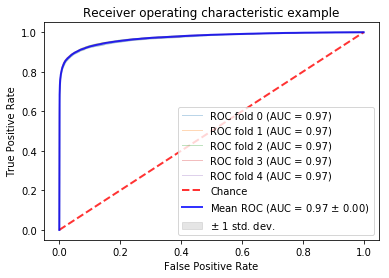

CPU times: user 2h 5min 27s, sys: 1min 2s, total: 2h 6min 29s
Wall time: 34min 40s


In [4]:
%%time

cv = StratifiedKFold(n_splits=5,shuffle=True)
clf = lgb.LGBMClassifier(learning_rate=0.1,n_estimators=2000)

mean_auc, std_auc, test_accuracy_scores, train_accuracy_scores = utils.auc_plot(clf, cv, X_train, y_train)

In [ ]:
gc.collect()
clf.fit(X_train.drop(['TransactionID','TransactionDT'],axis=1), y_train)
y_submit = clf.predict_proba(test.drop(['TransactionID','TransactionDT'],axis=1))

In [ ]:
utils.write_submission(y_submit,'lightgbm_basic2_08_13_19.csv')
#utils.save_model(clf,mean(aucs))

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.drop(['TransactionID','TransactionDT'],axis=1).columns)), columns=['Value','Feature'])
feature_imp.sort_values(by='Value',ascending=False)